<a href="https://colab.research.google.com/github/minhducvo04/PyTorch-models/blob/main/PyTorch_Best_Model_Pizza_Steak_Sushi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import models
from torchvision import transforms
from torchvision.transforms import ToTensor 
from torchvision import datasets
from torch.utils.data import DataLoader

from typing import Tuple, Dict, List

from torch.utils.data import Dataset

from tqdm.auto import tqdm

from timeit import default_timer as timer

import random
from PIL import Image

from torchvision.datasets import ImageFolder

In [ ]:
# Device agnoistic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")

In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data")
image_path = data_path/ "Pizza_steak_sushi"

# If the image folder doesn't exist, download it...
if image_path.is_dir():
  print (f" {image_path} directory already exists... skipping download")
else:
  print (f" {image_path} does not exist, creating one...")
  image_path.mkdir(parents=True,exist_ok=True)

# Download pizza, steak, and sushi datasets
with open(data_path/ "pizza_steak_sushi.zip","wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print ("Downloading pizza, steak, suhsi data..." )
  f.write (request.content)

# Unzip the file
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip","r") as zip_ref:
  print("Unzipping pizza, steak, and sushi data...")
  zip_ref.extractall(image_path)

 data/Pizza_steak_sushi directory already exists... skipping download
Unzipping pizza, steak, and sushi data...


In [ ]:
import os
def walk_through_dir(dir_path):
  """Walks through dir path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
# Setup train and test paths
train_dir = image_path/"train"
test_dir = image_path/"test"

train_dir, test_dir

(PosixPath('data/Pizza_steak_sushi/train'),
 PosixPath('data/Pizza_steak_sushi/test'))

In [ ]:
def find_classes(directory:str) -> Tuple[List[str], Dict[str,int]]:
  """
  Finds the class folder names in a target directory
  """
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(target_directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}...")

  # 3. Create a dictionary of index labels (computer prefer numbers)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  
  return classes, class_to_idx
target_directory=train_dir
class_names=find_classes(target_directory)
class_names[1]

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Create a simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(512,512)),
    #transforms.TrivialAugmentWide(num_magnitude_bins=31),
    #transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

In [ ]:
# Load data
train_data_simple = ImageFolder(root=train_dir,
                                transform=simple_transform)
test_data_simple = ImageFolder(root=test_dir,
                                transform=simple_transform)
train_data_simple, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/Pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ), Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/Pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ))

In [ ]:
# Turn the datasets into dataloaders

# Set up batch size
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
RESOLUTION = 512

# Create dataloader
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=False)
train_dataloader_simple, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x7f90709b8a60>,
 <torch.utils.data.dataloader.DataLoader at 0x7f90aa68e100>)

In [ ]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int,
               resolution: int) -> None:
    super().__init__()
    self.__resolution__ = torch.round(torch.tensor([resolution*resolution/64]))[0].int() if resolution else 16
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=2,
                  padding=1,
                  stride = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=2,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride = 2)
        
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=2,
                  padding=1,
                  stride = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=2,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                  stride = 2)
        
    )
    self.conv_block_3 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=2,
                  padding=1,
                  stride = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=2,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                  stride = 2)
        
    )
    self.conv_block_4 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=2,
                  padding=1,
                  stride = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=2,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                  stride = 2)
        
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units * 9 * 121,
                  out_features=output_shape)
    )
  def forward(self, x):
    return self.classifier(self.conv_block_4(self.conv_block_3(self.conv_block_2(self.conv_block_1(x)))))


In [ ]:
# Create train_step
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  # Put the model in train mode
  model.train()

  # Set up train loss and accuracy
  train_loss, train_acc = 0,0

  # Loop through batches in dataloader
  for batch, (X,y) in enumerate(dataloader):
    
    # Send data to device
    X,y=X.to(device),y.to(device)
    
    # 1. Forward pass
    y_pred = model(X)

    # 2. Set up loss function
    loss = loss_fn(y_pred,y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss Backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # 6. Calculate accuracy
    y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # 7. Adjust metrics to get average loss and accuracy per batch
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc

In [ ]:
# Create test step
def test_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               device=device):
  # Put in eval mode
  model.eval()

  # Set up train loss and accuracy
  test_loss, test_acc = 0,0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through batches in dataloader
    for batch, (X,y) in enumerate(dataloader):
      # Send data to device
      X,y=X.to(device),y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits,y)
      test_loss += loss.item()

      # 3. Calculate accuracy
      test_pred_labels = torch.argmax(torch.softmax(test_pred_logits,dim=1),dim=1)
      test_acc += ((test_pred_labels==y).sum().item()/len(test_pred_labels))

  # 4. Adjust metrics to get average loss and accuracy per batch
  test_loss /= len(dataloader)
  test_acc /= len(dataloader)

  return test_loss, test_acc


In [ ]:
def train(model: torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          loss_fn:torch.nn.Module = nn.CrossEntropyLoss(),
          optimizer=torch.optim.Optimizer,
          epochs: int = 20,
          device = device):
  
  # Set up optimizer
  change = 0
  best = 100
  model_save = model
  # 1. Create empty result dictionary
  results = {"train_loss":[],
             "train_acc":[],
             "test_loss":[],
             "test_acc":[]}
  # 2. Loop through training and testing steps for a number of epoch
  for epoch in tqdm(range(epochs)):
    #optimizer=torch.optim.SGD(params=model.parameters(),
    #                              lr = learn)
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device = device)
    # 3. Print out what's happening
    print (f'Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.6f}')

    # 4. Update result dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    
    if results["test_loss"][-1] < best:
      model_save = model
      best = results["test_loss"][-1]
    
    #learn /= 1.2
  # 5. Return the result dictionary after loop
  return results, model_save

In [ ]:
## Save the best model

from pathlib import Path
# Create model dictory path
MODEL_PATH = Path( "models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)
# Create model save
MODEL_NAME = "PyTorch_Custom_Datasets.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
MODEL_SAVE_PATH

PosixPath('models/PyTorch_Custom_Datasets.pth')

In [ ]:
# Create new instance 
torch.manual_seed(42)
loaded_model_0 = TinyVGG(input_shape = 3,
                  hidden_units = 8,
                  output_shape = len(class_names[1]),
                  resolution=512).to(device)

loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH ))
# Send model to targeted device
loaded_model_0.to(device)
next(loaded_model_0.parameters()).device

device(type='cuda', index=0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
loss_fn = nn.CrossEntropyLoss()
test_loss, test_acc=test_step(model=loaded_model_0,
                      dataloader=train_dataloader_simple,
                      loss_fn=loss_fn,
                      device=device)
print(f'Test loss: {test_loss:.4f} | Test acc: {test_acc:.6f}')


Test loss: 0.0781 | Test acc: 1.000000


## Loading in custom image
We have to make sure our custom image is in the same format as the data our model was trained on.
• In tensor form with datatype (torch.float32)
• Of shape 512×512x3
• On the right device
We can read an image into PyTorch using

In [ ]:
# Steak picture
custom_image_path = []
custom_image_path.append(data_path / "Test_Steak!.jpeg")
# Download the image if it doesn't already exist
if not custom_image_path[0].is_file():
  with open(custom_image_path[0],"wb") as f:
    # When downloading from GitHub, need to use the "raw" file link
    request = requests.get ("https://www.seriouseats.com/thmb/-KA2hwMofR2okTRndfsKtapFG4Q=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/__opt__aboutcom__coeus__resources__content_migration__serious_eats__seriouseats.com__recipes__images__2015__05__Anova-Steak-Guide-Sous-Vide-Photos15-beauty-159b7038c56a4e7685b57f478ca3e4c8.jpg")
    print(f"Downloading {custom_image_path[0]}...")
    f.write(request.content)
else:
  print (f"{custom_image_path[0]} already exists, skipping download...")

data/Test_Steak!.jpeg already exists, skipping download...


In [ ]:
# Pizza picture
custom_image_path.append( data_path / "Test_Pizza!.jpeg")
if not custom_image_path[1].is_file():
  with open(custom_image_path[1],"wb") as f:
    request = requests.get ("https://upload.wikimedia.org/wikipedia/commons/thumb/a/a3/Eq_it-na_pizza-margherita_sep2005_sml.jpg/800px-Eq_it-na_pizza-margherita_sep2005_sml.jpg")
    print(f"Downloading {custom_image_path[1]}...")
    f.write(request.content)
else:
  print (f"{custom_image_path[1]} already exists, skipping download...")

data/Test_Pizza!.jpeg already exists, skipping download...


In [ ]:
# Sushi picture
custom_image_path.append( data_path / "Test_Sushi!.jpeg")
if not custom_image_path[2].is_file():
  with open(custom_image_path[2],"wb") as f:
    request = requests.get ("https://www.pressurecookrecipes.com/wp-content/uploads/2021/02/california-roll.jpg")
    print(f"Downloading {custom_image_path[2]}...")
    f.write(request.content)
else:
  print (f"{custom_image_path[2]} already exists, skipping download...")

data/Test_Sushi!.jpeg already exists, skipping download...


In [ ]:
custom_image = []
for i in custom_image_path:
  custom_image.append( torchvision.io.read_image(str(i)))
custom_image[2].shape

torch.Size([3, 1057, 1800])

In [ ]:
for i in range(len(custom_image)):
  print(i)

0
1
2


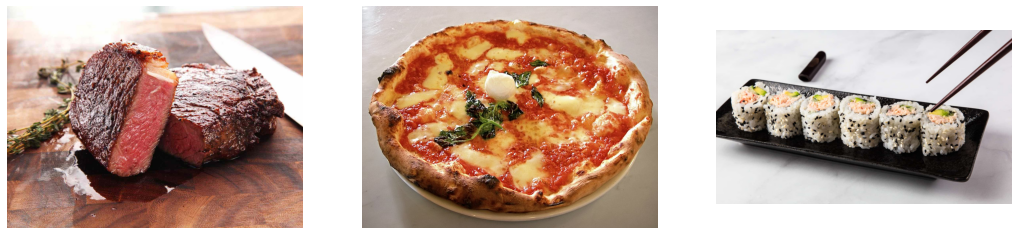

In [ ]:
nrows = 1
ncols = 3
plt.figure(figsize=(18,6))
for i, sample in enumerate(custom_image):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow((sample.type(torch.float32)/255).permute(1,2,0))
  plt.axis(False);

In [ ]:
# Create a simple transform
transform = transforms.Compose([
    transforms.Resize(size=(512,512))
    #transforms.TrivialAugmentWide(num_magnitude_bins=31),
    #transforms.TrivialAugmentWide(num_magnitude_bins=31)
    #transforms.ToTensor()
])

In [ ]:
from numpy.core.memmap import ndarray
custom_image_transformed = []
for i,custom_i in enumerate(custom_image):
  custom_i = (custom_i.type(torch.float32))
  custom_i= custom_i/255
  custom_image_transformed.append(transform(custom_i))
custom_image_transformed[0].shape

torch.Size([3, 512, 512])

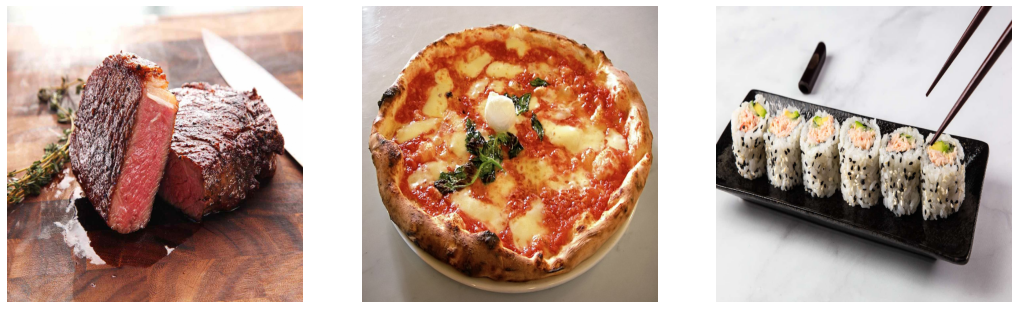

In [ ]:
nrows = 1
ncols = 3
plt.figure(figsize=(18,6))
for i, sample in enumerate(custom_image_transformed):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.permute(1,2,0))
  plt.axis(False);

In [ ]:
# This should this work? (added a batch size...)
loaded_model_0.eval()
custom_image_pred = []
with torch.inference_mode():
  for i, sample in enumerate(custom_image_transformed):
    custom_image_pred.append(loaded_model_0(sample.unsqueeze(0).to(device)))
custom_image_pred[0]

tensor([[-3.8340, -1.2288, -2.5667]], device='cuda:0')

In [ ]:
class_names

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

Note, to make a prediction on a custom image we had to:
* Load the image and turn it into a tensor
* Make sure the image was the same datatype as the model (torch.float32)
* Make sure the image was the same shape as the data the model was trained on (3, 64, 64) with a batch size... (1, 3, 64, 64)
* Make sure the image was on the same device as our model

In [ ]:
custom_image_pred_probs = []
for i, sample in enumerate(custom_image_pred):
  custom_image_pred_probs.append(torch.softmax(sample, dim = 1))
custom_image_pred_probs[0]

tensor([[0.0553, 0.7484, 0.1964]], device='cuda:0')

In [ ]:
custom_image_pred_labels = []
for i, sample in enumerate(custom_image_pred_probs):
  custom_image_pred_labels.append(torch.argmax(sample, dim = 1))
custom_image_pred_labels[0]

tensor([1], device='cuda:0')

## 11.3 Putting custom image prediction together: building a function
Ideal outcome:

A function where we pass an image path to and have our model predict on that image and plot the image + prediction.

In [ ]:
def pred_and_plot_image(model:torch.nn.Module,
                        image_path:List[str],
                        class_names:List[str]=None,
                        transform=None,
                        device=device):
  """Makes a prediction on a target image with a trained model and plot it all out"""
  nrows = 1
  ncols = 3
  plt.figure(figsize=(18,6))
  for i, sample in enumerate(image_path):
    plt.subplot(nrows, ncols, i+1)
    # Load image
    target_image = torchvision.io.read_image(str(sample)).type(torch.float32)

    # Divide it by 255 -> [0,1]
    target_image /= 255

    # Transform if necessary
    if transform:
      target_image = transform(target_image)
    
    # Make sure it on the target device
    model.to(device)

    # Turn on evaluation mode
    model.eval()
    with torch.inference_mode():
      # Add an extra dimension (This is the batch dimension)
      target_image = target_image.unsqueeze(0)

      # Make prediction
      target_image_pred = model(target_image.to(device))

      # Prediction -> Prediction probabilities
      target_image_pred_probs = torch.softmax(target_image_pred, dim = 1)
      target_image_pred_probs

      # Prediction probabilities -> Choice
      target_image_pred_labels = torch.argmax(target_image_pred_probs, dim = 1)
      target_image_pred_labels

      # Plot the image with prediction
      plt.imshow(target_image.squeeze().permute(1,2,0)) # Remove the batch dimension and rearrange the dimension
      if class_names:
        title=(f'Pred: {class_names[target_image_pred_labels]} | Prob: {target_image_pred_probs.max().cpu():.3f}')
      else:
        title=(f'Pred: {target_image_pred_labels} | Prob: {target_image_pred_probs.max().cpu():.3f}')
      plt.title(title);
      plt.axis(False);

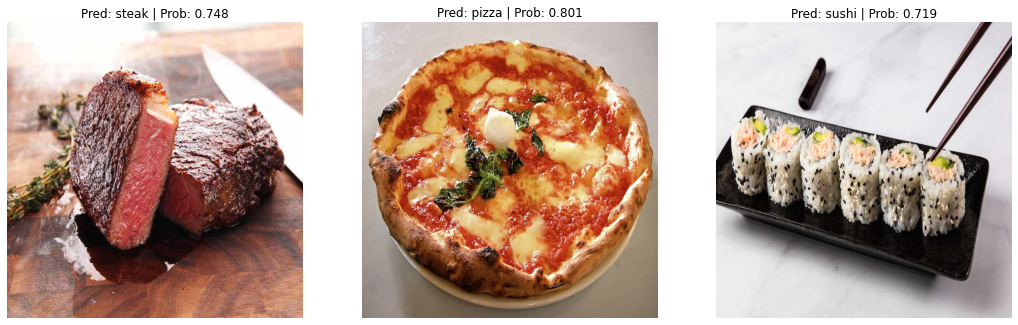

In [ ]:
pred_and_plot_image(model=loaded_model_0,
                    image_path=custom_image_path,
                    class_names=class_names[0],
                    transform=transform,
                    device=device)